In [1]:
from unityagents import UnityEnvironment
import numpy as np

from model import QNetwork
from dqn_agent import Agent

import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn.functional as F
import torch.optim as optim

In [2]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64", no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
agent: Agent= None

/home/rbianchi/miniconda3/envs/drlnd/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/rbianchi/miniconda3/envs/drlnd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 100 Median Reward(100) 0.86 Reward Count 1 Average Reward Window 0.87878787878787884
Episode 200 Median Reward(100) 4.04 Reward Count 0 Average Reward Window 3.956
Episode 300 Median Reward(100) 7.52 Reward Count 1 Average Reward Window 7.533
Episode 400 Median Reward(100) 10.28Reward Count 0 Average Reward Window 10.22
Episode 482 Step 299 Reward 0.0 Neg Reward Count 0 Average Reward Window 12.472
Environment solved in 382 episodes!
Average Score: 12.49


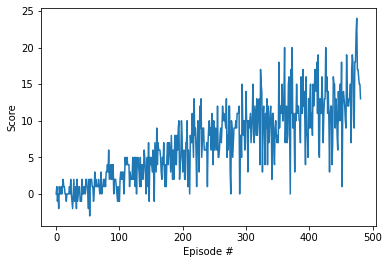

In [5]:
def dqn(n_episodes=1800, max_t=500, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    env_info = env.reset(train_mode=True)[brain_name]
    state_size = env_info.vector_observations.shape[1]
    nA:int = brain.vector_action_space_size

    agent = Agent(state_size=state_size, action_size=nA, seed=None)
    scores = []                         # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start     
    
    last_median = 0.0
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]

        
        state = env_info.vector_observations[0] 
        score = 0
        neg_count = 0

        for t in range(max_t):
            action = agent.act(state, eps)        # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0] 

            if reward < 0:
                neg_count += 1

            print(f'Episode {i_episode} Step {t} Reward {reward} Neg Reward Count {neg_count} Average Reward Window {np.average(scores_window)}' , end='\r')
            agent.step(state, action, reward, next_state, done) 
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break

        scores_window.append(score)              # save most recent score
        scores.append(score)                     # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        if i_episode % 100 == 0:
            print(f'Episode {i_episode} Median Reward(100) {np.average(scores_window)}')
        if np.median(scores_window) >= 13.0: #or (i_episode % 1500 == 0 and np.median(scores_window) >= last_median):
            print('\nEnvironment solved in {:d} episodes!\nAverage Score: {:.2f}'.format(i_episode-100, np.average(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            # if np.median(scores_window) >= 15.0:
            #     break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [6]:
env.close()

In [3]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64", no_graphics=False)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

state_size = env_info.vector_observations.shape[1]
nA:int = brain.vector_action_space_size

agent_play = Agent(state_size=state_size, action_size=nA, seed=None)

agent_play.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

step = 0
while True:
    action = agent_play.act(state, 0.0)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    step += 1
    print(f'[{step}]Action {action} Reward {reward} ∑ Reward {score}', end='\r')	
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("\nTotal Score: {}".format(score))

[300]Action 0 Reward 0.0 ∑ Reward 10.0
Total Score: 10.0
